# roAp Classification using regression techniques:

### Updates:
        initial: (03/2/2023)
        linear regression: (04/4/2023)
        classification: (04/13/2023)

In [3]:
from sklearn import neighbors, datasets, preprocessing, linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import gaussian_kde

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 1. Importing csv files containing NGC 2264 and known roAps
        'roAp' is the csv file including the field roAps
        'clust' is the csv file including NGC 2264 cluster stars
        'all' is the concatenated of the two

In [14]:
r = pd.read_csv('Data/field_roAp.csv', index_col=False)
c = pd.read_csv('Data/15MON_A0_FOV.csv', index_col=False)
rfeat = r.columns
cfeat = c.columns

roAp = pd.DataFrame(r)
clust = pd.DataFrame(c)
dbr = np.append(np.array(roAp), np.array(roAp), axis=1)
dbc = np.append(np.array(clust), np.array(clust), axis=1)
# Concatenating datasets to find roAp condidates in NGC 2264
all = pd.concat([roAp, clust],axis=0)
all['designation'] = all['designation'].str.replace(r'\D', '')
db = np.append(np.array(all),np.array(all),axis=1)
# Extracting features of all datasets
yr = (roAp['GMAG0']).values
yc = (clust['GMAG0']).values
xr = (roAp['BP-RP0']).values
xc = (clust['BP-RP0']).values
y = (all['GMAG0']).values
x = (all['BP-RP0']).values

print('Features:', len(yr))
print('Target:', len(yc))
print('---------')
print('Total Dataset for field roAps:', dbr.data.shape)
print('Total Dataset for NGC 2264:', dbc.data.shape)
print('Concatenated Dataset:',all.shape)
all.describe()

/tmp/ipykernel_11065/1649100.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  all['designation'] = all['designation'].str.replace(r'\D', '')


Features: 93
Target: 965
---------
Total Dataset for field roAps: (93, 120)
Total Dataset for NGC 2264: (965, 172)
Concatenated Dataset: (1058, 90)


,num,id,ra,RA_ICRS,dec,DE_ICRS,GMAG0,BP-RP0,ecl_lon,ecl_lat,...,grvs_mag,grvs_mag_error,logg_gspphot,mh_gspphot,phot_bp_mean_flux,phot_bp_mean_flux_error,phot_g_mean_flux,phot_g_mean_flux_error,phot_rp_mean_flux,phot_rp_mean_flux_error
count,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,1058.000000,...,127.000000,127.000000,846.000000,846.000000,9.650000e+02,965.000000,9.650000e+02,965.000000,9.650000e+02,965.000000
mean,0.087902,528.500000,109.151299,109.151289,7.478114,7.478106,3.442366,0.757858,109.771502,-13.118243,...,12.503708,0.073577,4.376956,-1.251781,2.165922e+04,74.888334,4.196140e+04,21.822412,2.990228e+04,77.776609
std,0.283286,305.562596,41.211886,41.211825,13.838901,13.838930,2.109317,0.467252,42.045784,12.764718,...,1.210838,0.063511,0.459858,1.033316,1.807347e+05,1115.473325,3.672976e+05,110.827438,2.778614e+05,1033.807892
min,0.000000,0.000000,2.127157,2.127157,-81.902104,-81.902104,-2.724406,-0.274474,2.019759,-85.377605,...,7.257843,0.005903,1.560400,-4.080400,9.493662e+01,5.431366,7.524995e+02,1.351323,7.388467e+02,6.360226
25%,0.000000,264.250000,100.119403,100.119403,9.797506,9.797506,2.154758,0.536962,100.236203,-13.265848,...,12.066604,0.029815,4.194500,-1.636250,3.390643e+02,11.071645,1.269774e+03,2.042505,1.384733e+03,12.372756
50%,0.000000,528.500000,100.244704,100.244704,9.920538,9.920538,3.409107,0.713893,100.364398,-13.137302,...,12.808246,0.062369,4.455300,-1.098800,6.898837e+02,14.236284,2.602011e+03,2.892261,2.781346e+03,15.658791
75%,0.000000,792.750000,100.431403,100.431403,10.019111,10.019111,4.361791,0.921099,100.558289,-13.049704,...,13.332334,0.105035,4.713975,-0.429025,2.274583e+03,20.523827,7.898782e+03,6.651048,8.173050e+03,24.481014
max,1.000000,1057.000000,348.317184,348.305087,58.526905,58.526905,13.284124,3.569711,336.146049,69.335987,...,14.090522,0.507102,5.158000,0.635400,4.076147e+06,34367.074000,9.490580e+06,2162.942900,7.721012e+06,31803.912000


#### ~ Plotting the initial HRD with the field roAps and NGC 2264

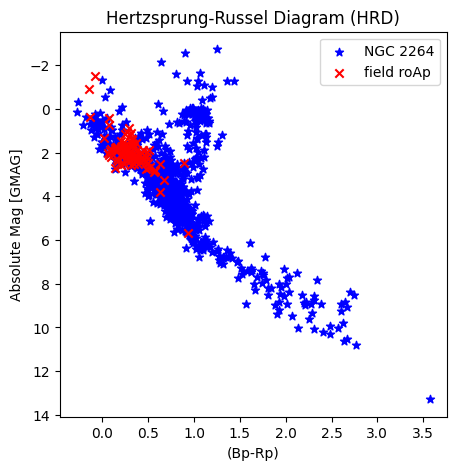

In [15]:
plt.figure(figsize=(5,5))
plt.scatter(x=xc,y=yc,marker='*', c='b', label='NGC 2264')
plt.scatter(x=xr,y=yr,marker='x', c='r', label='field roAp')
plt.legend()
plt.title('Hertzsprung-Russel Diagram (HRD)')
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('(Bp-Rp)')
plt.gca().invert_yaxis()

----

### 2. Splitting the data to be used for training and showing the sizes

In [16]:
column = 0

# Splitting data 80:20

xtrain, xtest, ytrain, ytest = train_test_split(db[:,np.newaxis,8],
                                                db[:,7],train_size=0.8)

xtrain_r, xtest_r, ytrain_r, ytest_r = train_test_split(dbr[:,np.newaxis,8],
                                                        dbr[:,7],train_size=0.8)

xtrain_c, xtest_c, ytrain_c, ytest_c = train_test_split(dbc[:,np.newaxis,8],
                                                        dbc[:,7],train_size=0.8)

scalar = preprocessing.StandardScaler().fit(xtrain)
xtrain = scalar.transform(xtrain)
xtest = scalar.transform(xtest)

print(f"roAp->\nTrain: {xtrain_r.shape}, Label: {ytrain_r.shape}")
print(f"Test: {xtest_r.shape}, Label: {ytest_r.shape}")
print('-----------------')
print(f"cluster->\nTrain: {xtrain_c.shape}, Label: {ytrain_c.shape}")
print(f"Test: {xtest_c.shape}, Label: {ytest_c.shape}")
print('-----------------')
print(f"Concat->\nTrain: {xtrain.shape}, Label: {ytrain.shape}")
print(f"Test: {xtest.shape}, Label: {ytest.shape}")

roAp->
Train: (74, 1), Label: (74,)
Test: (19, 1), Label: (19,)
-----------------
cluster->
Train: (772, 1), Label: (772,)
Test: (193, 1), Label: (193,)
-----------------
Concat->
Train: (846, 1), Label: (846,)
Test: (212, 1), Label: (212,)


----

### 3. Training the Linear Regression model and plotting with the HRD

Coefficient for roAp or slope(m) in y = mx+b: [2.94833282]
Coefficient for cluster or slope(m) in y = mx+b: [3.14105161]

Mean squared error for roAp: 0.36
Mean squared error for cluster: 2.53

Coefficient of determination for roAp: 0.48
Coefficient of determination for cluster: 0.40


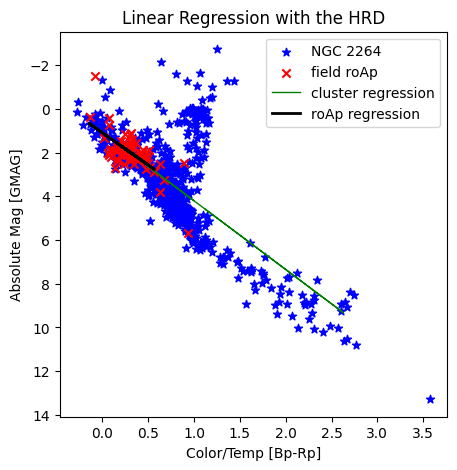

In [17]:
regr = LinearRegression()
regc = LinearRegression()
# Fitting/Training the model
regr.fit(xtrain_r,ytrain_r)
regc.fit(xtrain_c,ytrain_c)
# Predictions
data_r_pred = regr.predict(xtest_r)
data_c_pred = regc.predict(xtest_c)

# The coefficients
print(f"Coefficient for roAp or slope(m) in y = mx+b: {regr.coef_}")
print(f"Coefficient for cluster or slope(m) in y = mx+b: {regc.coef_}")
# The mean squared error
print("\nMean squared error for roAp: %.2f" % mean_squared_error(ytest_r, data_r_pred ))
print("Mean squared error for cluster: %.2f" % mean_squared_error(ytest_c, data_c_pred ))
# The coefficient of determination: 1 is perfect prediction
print("\nCoefficient of determination for roAp: %.2f" % r2_score(ytest_r, data_r_pred ))
print("Coefficient of determination for cluster: %.2f" % r2_score(ytest_c, data_c_pred ))

plt.figure(figsize=(5,5))
plt.title('Linear Regression with the HRD')
plt.scatter(x=xtrain_c,y=ytrain_c,marker='*', c='b', label='NGC 2264')
plt.scatter(x=xtrain_r,y=ytrain_r,marker='x', c='r', label='field roAp')
plt.gca().invert_yaxis()
plt.plot(xtest_c,data_c_pred,c='green',linewidth=1,label='cluster regression')
plt.plot(xtest_r,data_r_pred,c='black',linewidth=2,label='roAp regression')
plt.legend()
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.savefig('Figures/LinearRegHRD-both')

----

### 4. Training and plotting the concatenated dataset with the linear regression

#### ~ The following shows the FOV we want with the current data:

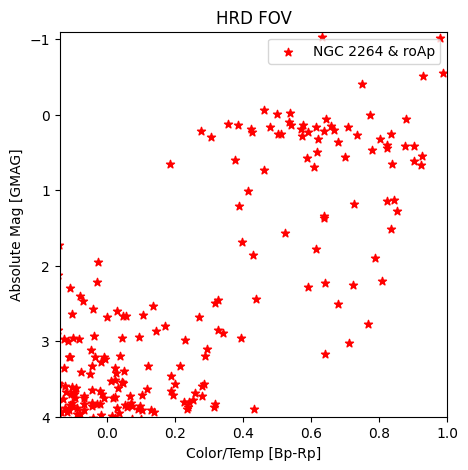

In [18]:
plt.figure(figsize=(5,5))
plt.title('HRD FOV')
plt.ylim([-1.1,4])
plt.xlim([-0.14,1])
plt.scatter(xtrain,ytrain,marker='*',c='r',label='NGC 2264 & roAp')
plt.gca().invert_yaxis()
plt.legend()
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.savefig('Figures/LinearRegHRD-concat.png')

#### ~ Fitting the roAp's regression to the concatenated dataset and finding the deviations:

In [19]:
# For field roAp's
regr.fit(xtrain_r,ytrain_r)
pred = regr.predict(xtrain)
predr = regr.predict(xtrain_r)
print("Regression Coefficient:", regr.coef_[0])
dist = np.abs(ytrain - pred)
print('Length of the deviation list:', len(dist))

Regression Coefficient: 2.948332818554892
Length of the deviation list: 846


#### ~ Computing which cluster stars are potential candidates using the deviations, threshold value, and the maximum B-R value:

In [20]:
print('Stars in NGC 2264 following the regression:')
cands = []
thresh = 1.5
max = (xr.max()) + 0.5
for n in range(len(ytrain)):
    if (dist[n]<thresh) & (xtrain[n]<max):
        cand = clust.iloc[n]['id']
        print('Deviation:', dist[n],'| ID:',cand, '| GMAG:', ytrain[n], '| B-R: ', xtrain[n][0])
        cands.append({'ID':cand,'Deviation':dist[n],'GMAG':ytrain[n],'B-R':xtrain[n][0]})

Stars in NGC 2264 following the regression:
Deviation: 1.416748287028979 | ID: 101 | GMAG: 2.599674 | B-R:  0.02882857275084003
Deviation: 1.0266779573192086 | ID: 131 | GMAG: 1.2119 | B-R:  0.3868791421114624
Deviation: 1.3466826176057551 | ID: 140 | GMAG: 2.864242 | B-R:  0.1423278586242858
Deviation: 0.9770025371584463 | ID: 155 | GMAG: 2.250628 | B-R:  0.7223407879659545
Deviation: 0.7626161742569879 | ID: 173 | GMAG: 2.223185 | B-R:  0.6403183780875508
Deviation: 1.3182626089476077 | ID: 198 | GMAG: 5.119092 | B-R:  0.9167553568662511
Deviation: 1.4467224158850245 | ID: 247 | GMAG: 4.917961 | B-R:  0.8049664825359223
Deviation: 1.4034419379027046 | ID: 263 | GMAG: 2.661548 | B-R:  0.05432784768111177
Deviation: 0.5769417774816334 | ID: 277 | GMAG: 1.687704 | B-R:  0.39572068808563826
Deviation: 0.5908360205701895 | ID: 285 | GMAG: 2.505641 | B-R:  0.6778568288406949
Deviation: 1.0676545094741574 | ID: 292 | GMAG: 1.570124 | B-R:  0.5222778832721074
Deviation: 1.1441718223417192 | 

### 5. Exporting potential candidates

#### ~ Writing the data to a csv file:

In [21]:
print(len(cands))
df = pd.DataFrame(cands)
df.to_csv('Data/candidates.csv',index=False,header=True)

df.describe()

45


,ID,Deviation,GMAG,B-R
count,45.000000,45.000000,45.000000,45.000000
mean,546.511111,0.949535,2.642851,0.388869
std,250.561698,0.395628,1.386150,0.384151
min,101.000000,0.052087,-0.228720,-0.301878
25%,346.000000,0.590836,1.948123,0.135404
50%,608.000000,1.042593,2.539740,0.339193
75%,731.000000,1.275691,2.959737,0.640862
max,926.000000,1.470562,6.609363,1.423636


#### ~ Displaying the candidates with the roAp's:

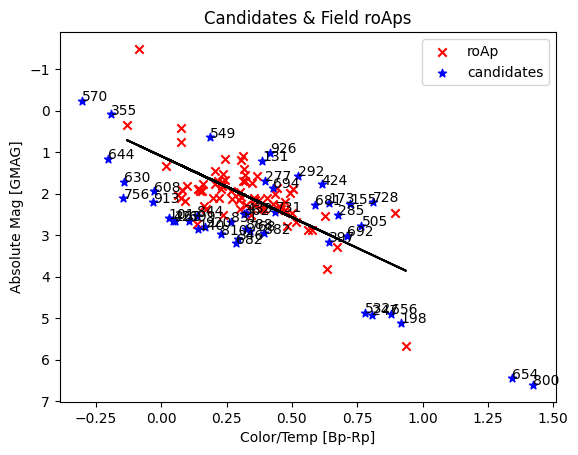

In [23]:
a = df['B-R']
b = df['GMAG']

plt.gca().invert_yaxis()
plt.title('Candidates & Field roAps')
plt.scatter(xtrain_r,ytrain_r,marker='x',c='r',label='roAp')
plt.scatter(a,b,marker='*',c='b',label='candidates')
plt.plot(xtrain_r,predr,c='black')
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend()

for i, id in enumerate(df['ID']):
    plt.annotate(id, (a[i],b[i]))
plt.savefig('Figures/Candidates')
plt.show()